In [54]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import toml
import torch
import joblib
from statsmodels.stats.multitest import multipletests
from torch.utils.data import DataLoader
from m6anet.utils.builder import random_fn
from m6anet.utils.data_utils import NanopolishDS, inference_collate
from m6anet.model.model import MILModel
from tqdm.notebook import tqdm
from pyensembl import Genome
from multiprocessing import Pool
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
selection_criteria = "pr_auc"
ROOT_PATH = "/home/christopher/m6anet/m6anet/"
NORM_PATH = os.path.join(ROOT_PATH, "model/norm_factors/norm_dict.joblib")
DEFAULT_MODEL_CONFIG = "../m6anet/model/configs/model_configs/1_neighbor/prod_pooling.toml"
DEFAULT_MODEL_WEIGHTS = "../m6anet/model/model_states/prod_pooling_pr_auc.pt"
MIN_READS = 20

In [3]:
def create_dl(input_dir, batch_size, num_workers):
    ds = NanopolishDS(input_dir, MIN_READS, NORM_PATH, mode='Inference')
    dl = DataLoader(ds, num_workers=num_workers, collate_fn=inference_collate, 
                    batch_size=batch_size, worker_init_fn=random_fn, shuffle=False)
    return dl

def get_read_level_probability(model, dl, device, n_iterations=1):
    """
    Run inference on unlabelled dataset
    """
    model.eval()
    all_y_pred = []
    with torch.no_grad():
        for n in range(n_iterations):
            y_pred_tmp = []
            for batch in dl:
                X = {key: val.to(device) for key, val in batch.items()}
                y_pred = model.get_read_probability(X)
                y_pred = 1 - torch.prod(1 - y_pred, axis=1)
                y_pred = y_pred.detach().cpu().numpy()
                if (len(y_pred.shape) == 1) or (y_pred.shape[1] == 1):
                    y_pred_tmp.extend(y_pred.flatten())
                else:
                    y_pred_tmp.extend(y_pred[:, 1])

            all_y_pred.append(y_pred_tmp)
    return np.mean(all_y_pred, axis=0)


In [4]:
device = 'cuda:2'
model_config = toml.load(DEFAULT_MODEL_CONFIG)
model_state_dict = torch.load(DEFAULT_MODEL_WEIGHTS, map_location=torch.device(device))

model = MILModel(model_config).to(device)
model.load_state_dict(model_state_dict)
model.eval()
batch_size = 512
num_workers = 25
hek293_dirs = ["/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-25_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-50_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTLE3-KO-75_directRNA_Rep1-Run1",
               "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1"]
hek293_dls = {input_dir.split("/")[-1]: create_dl(input_dir, batch_size, num_workers) for 
              input_dir in hek293_dirs}


In [104]:
def get_read_site_probability(model, dl, device, n_iterations=5):
    """
    Run inference on unlabelled dataset
    """
    model.eval()
    all_y_pred_read = []
    all_y_pred_site = []
    all_read_rep = []
    with torch.no_grad():
        for i in range(n_iterations):
            all_y_pred_read_tmp = []
            all_y_pred_site_tmp = []
            all_read_rep_tmp = []
            for batch in dl:
                X = {key: val.to(device) for key, val in batch.items()}
                y_pred_read, y_pred_site, read_rep = model.get_read_site_probability(X)
                all_y_pred_read_tmp.append(y_pred_read.detach().cpu().numpy().reshape(-1, 20, 1))
                all_y_pred_site_tmp.append(y_pred_site.detach().cpu().numpy().reshape(-1, 1))
                all_read_rep_tmp.append(read_rep.detach().cpu().numpy().reshape(-1, 20, 32))
            
            all_y_pred_read.append(np.concatenate(all_y_pred_read_tmp))
            all_y_pred_site.append(np.concatenate(all_y_pred_site_tmp))
            all_read_rep.append(np.concatenate(all_read_rep_tmp))
    return np.concatenate(all_y_pred_read, axis=1), np.concatenate(all_y_pred_site, axis=1), \
        np.concatenate(all_read_rep, axis=1)

In [105]:
wt_dl, ko_dl = hek293_dls['GohGIS_Hek293T_directRNA_Rep2'], hek293_dls['GohGIS_Hek293T-METTL3-KO_directRNA_Rep2_Run1']
wt_sites, ko_sites = wt_dl.dataset.data_info, ko_dl.dataset.data_info
wt_sites["wt_index"] = np.arange(len(wt_sites))
ko_sites["ko_index"] = np.arange(len(ko_sites))

shared_sites = wt_sites.merge(ko_sites, on=["transcript_id", "transcript_position"])
y_pred_read_wt, y_pred_site_wt, read_rep_wt = get_read_site_probability(model, wt_dl, device)
y_pred_read_ko, y_pred_site_ko, read_rep_ko = get_read_site_probability(model, ko_dl, device)
shared_sites["probability_modified_wt"] = shared_sites["wt_index"].apply(lambda x: np.mean(y_pred_site_wt[x]))
shared_sites["probability_modified_ko"] = shared_sites["ko_index"].apply(lambda x: np.mean(y_pred_site_ko[x]))

In [146]:
threshold = 0.5
high_confidence_positions = shared_sites[shared_sites["probability_modified_wt"] \
                                         - shared_sites["probability_modified_ko"] > threshold]
read_mask = (high_confidence_positions["n_reads_x"] >= 100) & (high_confidence_positions["n_reads_y"])
high_confidence_positions = high_confidence_positions[read_mask]

In [181]:
high_confidence_positions.reset_index(drop=True).iloc[idx]

,transcript_id,transcript_position,start_x,end_x,n_reads_x,wt_index,start_y,end_y,n_reads_y,ko_index,probability_modified_wt,probability_modified_ko
29,ENST00000381760,1238,382912473,382924522,139,29863,533794163,533802730,101,44752,0.667454,0.155321
83,ENST00000382581,1127,1117667617,1117677702,112,92861,1564874398,1564890409,183,139919,0.901119,0.282750
37,ENST00000312175,836,573012913,573034624,227,46135,795721929,795759110,373,69238,0.751136,0.128370
49,ENST00000225972,1309,770054218,770072097,196,62829,1075244561,1075260345,173,94552,0.934057,0.239051
80,ENST00000322723,2463,1102845906,1102858363,135,91227,1542118429,1542134454,165,137643,0.936801,0.165717


In [189]:
coords = high_confidence_positions.reset_index(drop=True).iloc[idx]\
    .apply(lambda x: x["transcript_id"] + "_" + str(x["transcript_position"]), axis=1)
coords
labels = np.concatenate([np.repeat(coord, 100) for coord in coords])


In [179]:
high_confidence_positions.reset_index(drop=True).iloc[idx]

,transcript_id,transcript_position,start_x,end_x,n_reads_x,wt_index,start_y,end_y,n_reads_y,ko_index,probability_modified_wt,probability_modified_ko
29,ENST00000381760,1238,382912473,382924522,139,29863,533794163,533802730,101,44752,0.667454,0.155321
83,ENST00000382581,1127,1117667617,1117677702,112,92861,1564874398,1564890409,183,139919,0.901119,0.282750
37,ENST00000312175,836,573012913,573034624,227,46135,795721929,795759110,373,69238,0.751136,0.128370
49,ENST00000225972,1309,770054218,770072097,196,62829,1075244561,1075260345,173,94552,0.934057,0.239051
80,ENST00000322723,2463,1102845906,1102858363,135,91227,1542118429,1542134454,165,137643,0.936801,0.165717


In [192]:
idx = np.random.choice(len(high_confidence_positions), 5, replace=False)
wt_indices = high_confidence_positions.reset_index(drop=True).iloc[idx]["wt_index"]
ko_indices = high_confidence_positions.reset_index(drop=True).iloc[idx]["ko_index"]
coords = high_confidence_positions.reset_index(drop=True).iloc[idx].apply(lambda x: x["transcript_id"] + "_" + \
                                                                              str(x["transcript_position"]), axis=1)

wt_reps = np.concatenate([read_rep_wt[idx] for idx in wt_indices])
ko_reps = np.concatenate([read_rep_ko[idx] for idx in ko_indices])
labels = np.concatenate([np.repeat(coord, 100) for coord in coords])
combined_reps = np.concatenate([wt_reps, ko_reps])
scaler = StandardScaler().fit(combined_reps)
pca = PCA(n_components=2).fit(scaler.transform(combined_reps))

to_plot_df = []
for wt_index, ko_index, ax, coord in zip(wt_indices, ko_indices, axes, coords):
    wt_rep = read_rep_wt[wt_index]
    ko_rep = read_rep_ko[ko_index]

    wt_read_prob = y_pred_read_wt[wt_index].flatten()
    ko_read_prob = y_pred_read_ko[ko_index].flatten()
    
    combined_rep = np.concatenate([wt_rep, ko_rep])
    combined_rep = scaler.transform(combined_rep)
    combined_rep = pca.transform(combined_rep)

    to_plot = pd.DataFrame({'PC1': combined_rep[:, 0], 'PC2': combined_rep[:, 1],
                            'read_probability': np.concatenate([wt_read_prob, ko_read_prob]),
                            'data_type': np.concatenate([np.repeat("WT", 100), np.repeat("KO", 100)])})
    
    to_plot["site"] = coord
    to_plot_df.append(to_plot)
#     sns.scatterplot(x='PC1', y='PC2', hue="data_type", size="read_probability", data=to_plot, 
#                     ax=ax)
to_plot_df = pd.concat(to_plot_df)
to_plot_df

In [230]:
def custom_scatter(x, y, c, s, **kwargs):
    sns.scatterplot(x, y, hue=c, size = s, **kwargs)

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

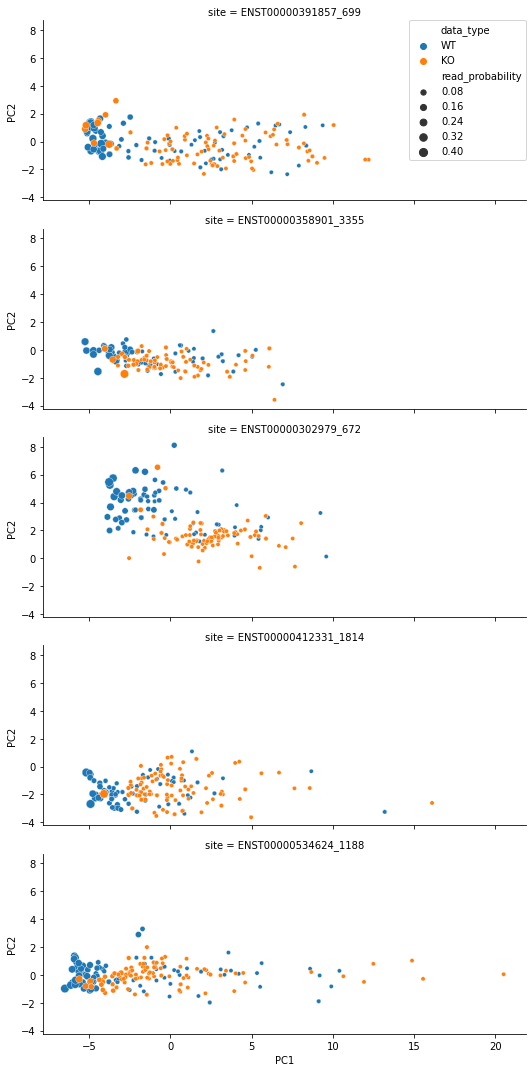

In [241]:
g = sns.FacetGrid(row="site", data=to_plot_df, height=3, aspect=2.5, sharex=True, sharey=True,
                  legend_out=True)
g.map(custom_scatter, 'PC1', 'PC2', 'data_type', 'read_probability')
g.axes[0][0].legend(loc='upper right', borderaxespad=0.)

In [248]:
from pyensembl import Genome
from tqdm.notebook import tqdm

def get_y(info_df, table, col_name):
    g, chrsm = info_df["genomic_position"].values, info_df["chr"].values
    info_df[col_name] = np.array([1 if (g_pos, chr_id) in table.index else 0
                                               for g_pos, chr_id in tqdm(zip(g, chrsm), total=len(g),
                                               desc="Getting label information")]) 
    return info_df


def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)


chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
gt_dir = "/data03/christopher/gt_mapping_final/"

chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

In [252]:
shared_df = None
ko_pcts = ["KO_0", "KO_25", "KO_50", "KO_75", "KO_100"]
features = ["gene_id", "genomic_position", "probability_modified"]
for input_dir, ko_pct in zip(hek293_dirs, ko_pcts):
    result_fpath = os.path.join(input_dir, "prod_pooling", "data.result.csv")
    probability_df = pd.read_csv(result_fpath)
    probability_df = add_chromosome_and_gene_info(probability_df)
    probability_df = add_genomic_position(probability_df)
    
    probability_df = probability_df[features].groupby(["gene_id", "genomic_position"]).mean().reset_index()
    probability_df = probability_df.rename({'probability_modified': 'probability_modified_{}'.format(ko_pct)}, 
                                            axis=1)
    if shared_df is None:
        shared_df = probability_df
    else:
        shared_df = shared_df.merge(probability_df, on=["gene_id", "genomic_position"])


  0%|          | 0/4662 [00:00<?, ?it/s]

  0%|          | 0/6141 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

  0%|          | 0/4672 [00:00<?, ?it/s]

  0%|          | 0/6423 [00:00<?, ?it/s]

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

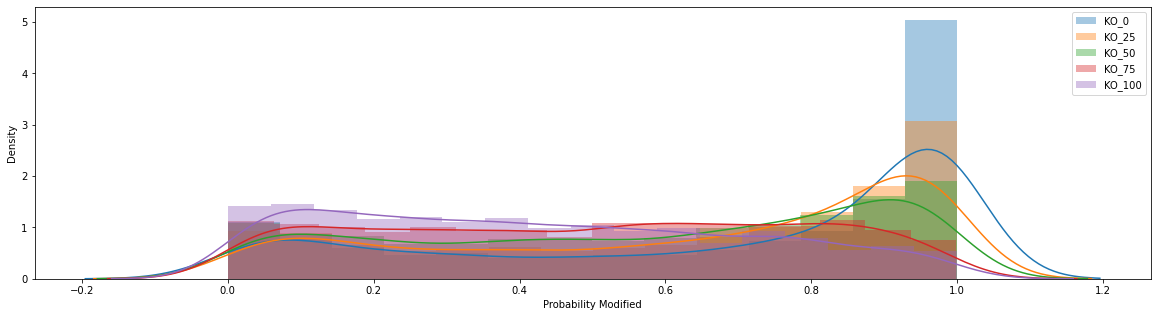

In [267]:
from statsmodels.stats.multitest import multipletests

ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
result_df_agg = shared_df.merge(ko_table, on=["gene_id", "genomic_position"])
result_df_agg["pvalue"] = multipletests(result_df_agg.pvalue, alpha=alpha, method='fdr_bh')[1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True, sharey=True)
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]
mask = result_df_agg["pvalue"] < alpha
for col, ko_pct in zip(proba_cols, ko_pcts):
    sns.distplot(result_df_agg[mask][col], ax=ax, label=ko_pct)

ax.set_xlabel("Probability Modified")
plt.legend()

There are 65 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

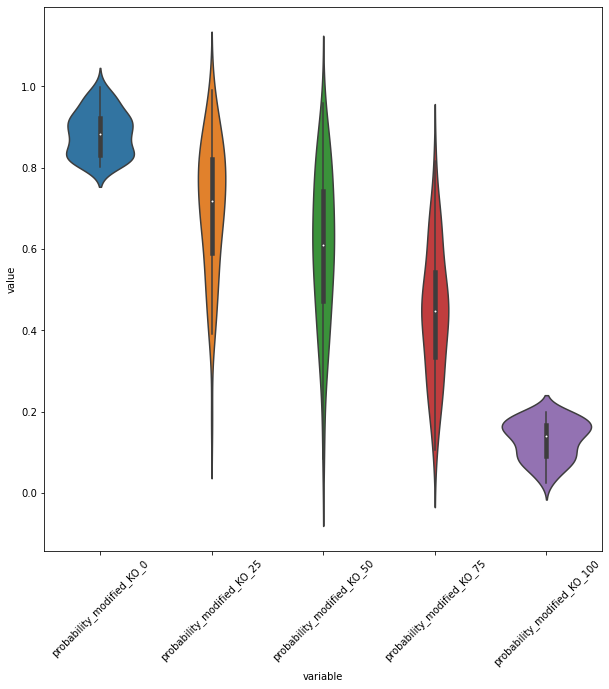

In [269]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

mask = result_df_agg["pvalue"] < alpha
confidence_mask = (result_df_agg["probability_modified_KO_0"] >= 0.8) & \
    (result_df_agg["probability_modified_KO_100"] < 0.2)

mask = mask & confidence_mask
result_df_agg_filtered = result_df_agg[mask]
print("There are {} sites in the plot".format(len(result_df_agg_filtered)))

result_df_agg_filtered_melt = pd.melt(result_df_agg_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=result_df_agg_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)

There are 104 sites in the plot


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'probability_modified_KO_0'),
  Text(1, 0, 'probability_modified_KO_25'),
  Text(2, 0, 'probability_modified_KO_50'),
  Text(3, 0, 'probability_modified_KO_75'),
  Text(4, 0, 'probability_modified_KO_100')])

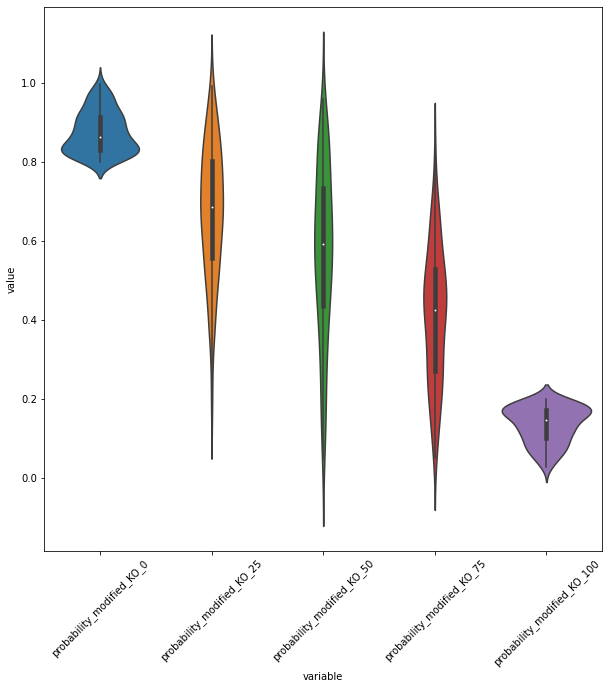

In [263]:
keys = ["gene_id", "genomic_position"]
proba_cols = ["probability_modified_{}".format(ko_pct) for ko_pct in ko_pcts]

confidence_mask = (shared_df["probability_modified_KO_0"] >= 0.8) & \
    (shared_df["probability_modified_KO_100"] < 0.2)

shared_df_filtered = shared_df[confidence_mask]
print("There are {} sites in the plot".format(len(shared_df_filtered)))

shared_df_filtered_melt = pd.melt(shared_df_filtered, value_vars=proba_cols)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.violinplot(x="variable", y="value", data=shared_df_filtered_melt,
               order=proba_cols,
               ax=ax)
plt.xticks(rotation=45)